In [1]:
import os
import numpy as np
import pandas as pd
from scipy.sparse import issparse
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def extract_gene_data(h5ad_path, gene_name="Xist", layer=None):
    """
    Extract and combine data for a specific gene

    Parameters:
    h5ad_path (str): Path to .h5ad file
    gene_name (str): Gene symbol to extract
    layer (str): Specific layer to use (default: X matrix)

    Returns:
    pd.DataFrame: Combined dataframe with cell metadata, gene expression,
                  and gene metadata for specified gene
    """
    adata = anndata.read_h5ad(h5ad_path)

    # Validate gene exists
    if gene_name not in adata.var_names:
        raise ValueError(f"Gene {gene_name} not found in dataset")

    # Extract gene expression
    gene_idx = adata.var_names.get_loc(gene_name)
    expression = (
        adata.X[:, gene_idx] if layer is None else adata.layers[layer][:, gene_idx]
    )

    if issparse(expression):
        expression = expression.toarray().flatten()

    # Create combined dataframe
    combined_df = adata.obs.copy()
    combined_df["expression"] = expression

    # Add gene metadata as constant columns
    gene_metadata = adata.var.loc[gene_name].to_dict()
    for k, v in gene_metadata.items():
        combined_df[f"gene_{k}"] = v  # Prefix to avoid column conflicts

    return combined_df


def save_gene_names(h5ad_path, output_file="gene_names.txt"):
    """
    Extract all gene names from an H5AD file and save them to a text file.

    Parameters:
    h5ad_path (str): Path to the H5AD file
    output_file (str): Name of the output text file (default: 'gene_names.txt')

    Returns:
    str: Path to the saved text file
    """
    # Read the H5AD file
    adata = anndata.read_h5ad(h5ad_path)

    # Extract gene names
    gene_names = adata.var_names.tolist()

    # Determine the output directory (same as H5AD file)
    output_dir = os.path.dirname(h5ad_path)
    output_path = os.path.join(output_dir, output_file)

    # Write gene names to the text file
    with open(output_path, "w") as f:
        for gene in gene_names:
            f.write(f"{gene}\n")

    print(f"Gene names saved to: {output_path}")
    print(f"Total genes: {len(gene_names)}")

    return output_path


# Example usage:
# save_gene_names("path/to/your/file.h5ad")

In [3]:
folder = "/Volumes/guttman/Guoming_Gao-Resnick/swift_seq/Alexs_1b_reads_4conditions"
os.chdir(folder)
df_A_all = extract_gene_data("ConditionA-GeneFull-StarSolo-all.h5ad", "Xist")
df_B_all = extract_gene_data("ConditionB-GeneFull-StarSolo-all.h5ad", "Xist")
df_C_all = extract_gene_data("ConditionC-GeneFull-StarSolo-all.h5ad", "Xist")
df_D_all = extract_gene_data("ConditionD-GeneFull-StarSolo-all.h5ad", "Xist")

In [5]:
df_A_all.keys()

Index(['id', 'cell_counts', 'n_genes', 'percent_mito', 'expression',
       'gene_gene_id', 'gene_gene_name', 'gene_gene_counts', 'gene_n_cells'],
      dtype='object')

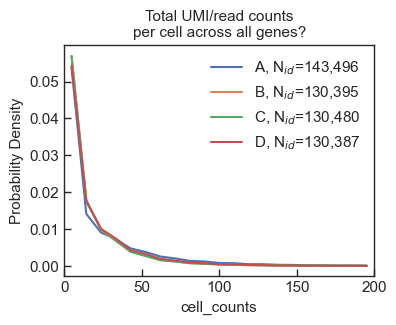

In [25]:
# cell_counts: Represents the total UMI/read counts per cell across all genes.
x_max = 200
hist_A, bins_edge = np.histogram(
    df_A_all.cell_counts, bins=21, range=(0, x_max), density=True
)
hist_B, bins_edge = np.histogram(
    df_B_all.cell_counts, bins=21, range=(0, x_max), density=True
)
hist_C, bins_edge = np.histogram(
    df_C_all.cell_counts, bins=21, range=(0, x_max), density=True
)
hist_D, bins_edge = np.histogram(
    df_D_all.cell_counts, bins=21, range=(0, x_max), density=True
)
midpoints = (bins_edge[:-1] + bins_edge[1:]) / 2
plt.figure(figsize=(4, 3))
plt.plot(midpoints, hist_A, label=r"A, N$_{id}$=" + f"{df_A_all.shape[0]:,}")
plt.plot(midpoints, hist_B, label=r"B, N$_{id}$=" + f"{df_B_all.shape[0]:,}")
plt.plot(midpoints, hist_C, label=r"C, N$_{id}$=" + f"{df_C_all.shape[0]:,}")
plt.plot(midpoints, hist_D, label=r"D, N$_{id}$=" + f"{df_D_all.shape[0]:,}")
plt.xlim(0, x_max)
plt.legend(frameon=False)
# adjust
plt.title('Total UMI/read counts\nper cell across all genes?', fontsize=11)
plt.xlabel(r"cell_counts", fontsize=11)
plt.ylabel(r"Probability Density", fontsize=11)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=11,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.savefig("hist_cell_counts_across_4_conditions.png", format="png", dpi=300)